## TensorFlow2 training loop control using default *tf.fit(...)* function

### Task Descripton

Up to now custom training loop in Tensorflow2 requires writing two lops:
1. loop iterating through epochs 
2. loop iterating through batches 

Then all castom training precudere will have to be implemented in these double-loop block of code. It's neither elegant nor robust due to the missing advanced features of *tf.fit(...)*.

In [5]:
import tensorflow as tf
from typing import Dict, Any, List, Tuple
import functools
from tensorflow_addons.utils import types
from typeguard import typechecked
import numpy as np
import argparse
from scipy.stats import truncnorm
import ast

In [6]:

BATCH_SIZE = 64

parser = argparse.ArgumentParser()
parser.add_argument("-o", "--output", dest="output", default="naly_syn_simple_arith")
parser.add_argument("-d", "--dist", dest="dist", default="normal", help="Prob.Dist")
parser.add_argument(
    "-p", "--params", dest="params", default="(-3,3)", type=ast.literal_eval
)
parser.add_argument("-e", "--ext", dest="ext", default="(10,15)", type=ast.literal_eval)

parser.add_argument("-n", "--nalu", dest="nalu", default="nalui1")
parser.add_argument("-se", "--seed", dest="seed", default=42, type=int)
parser.add_argument("-op", "--operation", dest="op", default="MUL")


args = parser.parse_args("")

def sample(dist, params, numDim=3, numDP=64000):
    data = np.zeros(shape=(numDP, numDim))
    if dist == "normal":
        intmean = (params[0] + params[1]) / 2
        intstd = (params[1] - params[0]) / 6
        print(
            "Generating Data: \nInt: \tdist \t %s\n\t\tdata >=\t %s\n\t\tmean(s)\t %s\n\t\tdata <\t %s\n\t\tstd \t %s"
            % (dist, params[0], intmean, params[1], intstd)
        )
        mi, ma = (params[0] - intmean) / intstd, (params[1] - intmean) / intstd
        data = np.reshape(
            truncnorm.rvs(mi, ma, intmean, intstd, size=numDim * numDP), data.shape
        )

    elif dist == "uniform":
        print(
            "Generating Data: \nInt: \tdist \t %s\n\t\tdata >=\t %s\n\t\tdata <\t %s\n\t\t"
            % (dist, params[0], params[1])
        )
        data = np.reshape(
            np.random.uniform(params[0], params[1], size=numDim * numDP), data.shape
        )
    elif dist == "exponential":
        data = np.random.exponential(params, size=(numDP, numDim))
    else:
        raise Exception("Unknown distribution")
    data = np.reshape(data, [-1])  # reshape to mix both distributions per instance!
    np.random.shuffle(data)
    data = np.reshape(data, (numDP, numDim))
    return data

def operation(op, a, b):
    if op.lower() == "mul":
        return a * b
    if op.lower() == "add":
        return a + b
    if op.lower() == "sub":
        return a - b
    if op.lower() == "div":
        return a / b

input_dim = 7
output_dim = 1

def data_comb(data):
    return (data[:, 0] - data[:, 1]) *  (data[:, 2] - data[:, 3]) +  (data[:, 4] * data[:, 5]) 

data = sample(args.dist, args.params, input_dim)
lbls =  data_comb(data)
lbls = np.reshape(lbls, newshape=(-1, 1))

int_data = sample(args.dist, args.params, input_dim)
int_lbls =  data_comb(int_data)
int_lbls = np.reshape(int_lbls, newshape=(-1, 1))


ext_data = sample(args.dist, args.ext, input_dim)
ext_lbls =  data_comb(ext_data)
ext_lbls = np.reshape(ext_lbls, newshape=(-1, 1))


data_dp = tf.data.Dataset.from_tensor_slices((data, lbls)).prefetch(tf.data.AUTOTUNE).batch(BATCH_SIZE)
int_data_dp = tf.data.Dataset.from_tensor_slices((int_data, int_lbls)).prefetch(tf.data.AUTOTUNE)
ext_data_dp = tf.data.Dataset.from_tensor_slices((ext_data, ext_lbls)).prefetch(tf.data.AUTOTUNE)

Generating Data: 
Int: 	dist 	 normal
		data >=	 -3
		mean(s)	 0.0
		data <	 3
		std 	 1.0
Generating Data: 
Int: 	dist 	 normal
		data >=	 -3
		mean(s)	 0.0
		data <	 3
		std 	 1.0
Generating Data: 
Int: 	dist 	 normal
		data >=	 10
		mean(s)	 12.5
		data <	 15
		std 	 0.8333333333333334


In [7]:
def bind(instance, func, as_name=None):
    """
    Bind the function *func* to *instance*, with either provided name *as_name*
    or the existing name of *func*. The provided *func* should accept the 
    instance as the first argument, i.e. "self".
    """
    if as_name is None:
        as_name = func.__name__
    bound_method = func.__get__(instance, instance.__class__)
    setattr(instance, as_name, bound_method)
    return bound_method

In [8]:
class LoopControlerCallback(tf.keras.callbacks.Callback):
    def __init__(
        self, 
        config: int, 
        reinit_config: Dict[str, Any] = None, 
        default_in_branch: Dict[str, Any] = {
                "loss": True, 
                "regularize": None, 
                "clipping": None,
                "variables": None,
                "excluded_variables": None,
            },
            verbose: bool = True,
            *args, **kwargs
    ) -> None:
        super(LoopControlerCallback, self).__init__(*args, **kwargs)
        self.default_in_branch: Dict[str, Any] = default_in_branch
        self.config: Dict[str, Any] = config
        self.reinit_config = reinit_config
        self.verbose: bool = verbose

    def on_train_begin(self, logs=None):
        """Function called directely before training. It is executed on each call of model.fit with this callback.
            Inside the scope of this funciton we can access model on which this callback works: self.model.

        Args:
            logs (_type_, optional): _description_. Defaults to None.
        """

        # meta attributes for building conditions
        self.epochs: int = 0
        self.batches: int = 0
        self.history: List[Any] = []

        # meta attributes for reinitialization handeling
        self.reinit_epochs: int = 0
        self.reinit_batches: int = 0
        self.reinit_history: List[Any] = []
        self.reinit_current_history: List[Any] = []
        
        # extend config with validation step
        self.config = self._extend_config(self.config)

        # assign active and exluded variables for slave steps
        self._extract_substeps_varialbe_arrays(self.config)

        # bind control variables and control conditions
        self._bind_controlers(self.config)
        
        # bind master train_step to model
        self._bind_master_step(self.config)

        # bind slave train_steps to model
        self._bind_slaves_steps(self.config)

        # bind reinitalization functionality to model only if reinitalizatoin config is provided
        if self.reinit_config:
            self._bind_reinitialization(self.reinit_config)


        # test
        self.model.optimizer.build(self.model.trainable_variables) 

    def _bind_master_step(self, config: Dict[str, Any]) -> None:
        lscope = locals()
        def _get_losses(config: Dict[str, Any]) -> str:
            def _substeps_condition_execution(name: str, config: Dict[str, Any], on: bool) -> str:
                if on:
                    return f"self.{name}_on(data)" if True in config else "0.0"
                else:
                    return f"self.{name}_off(data)" if False in config else "0.0"
                    
            return "{" + ",".join([
                        f"'loss_{an}' : tf.cond(self.control_variables['{an}'], lambda: {_substeps_condition_execution(an, ac, True)}, lambda: {_substeps_condition_execution(an, ac, False)})"
                        for an, ac in config.items()
                    ]) + "}"

        lscope = locals()
        function_body = """
@tf.function
def train_step(self, data):
    slave_loss = {losses_config}
    # losses = {{**{{'loss': slave_loss['loss_delay'] + slave_loss['loss_gate']}}, **slave_loss}}
    losses = {{**{{'loss': slave_loss['loss_gate']}}, **slave_loss}}
    metrics = {{m.name : m.result() for m in self.metrics}}
    metrics.pop("loss")
    control_states = {{
        control_name: tf.cond(
            control_value,
            lambda: tf.constant(True),
            lambda: tf.constant(False),
        )
        for control_name, control_value in self.control_variables.items()
    }}
    
    return {{**losses, **metrics, **control_states}}
""".format(
            **{"losses_config": _get_losses(config)}
        )

        if self.verbose:
            print("\n-------------------MASTER STEP-------------------")
            print(function_body)
        
        exec(function_body, {**globals(), **lscope}, lscope)
        bind(self.model, lscope["train_step"])

    def _bind_slaves_steps(self, config) -> None:
        
        if self.verbose:
            print("-------------------SLAVE STEPS-------------------\n")

        for action_name, action_config in config.items():
            if True in action_config:
                self._bind_slave_step(action_name, action_config[True], True)
            if False in action_config:
                self._bind_slave_step(action_name, action_config[False], False)
    
    def _bind_slave_step(self, action_name: str, fn_config: Dict[str, Any], branch: bool) -> None:
        

        lscope = {
            **locals(), 
            **fn_config
            }
        fn_name = self._get_actoin_step_name(action_name, branch)
        if fn_config["loss"]==False:
            # dummy error that will be anyway scale by 0 to make graph to compile otherwise
            # ---> 15     retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
            # ValueError: None values not supported.
            #######################################
            # OBSERVATION: loss function with y_pred and y_true must be consumed inside the gradient tape scope
            #######################################
            lscope["loss"] = self.model.compiled_loss

        function_body = f"""
@tf.function
def {fn_name}(self, data):
    x, y = data
    with tf.GradientTape(watch_accessed_variables={'False' if fn_config["variables"] or fn_config["excluded_variables"] else 'True'}) as tape:
        """

        if fn_config["variables"] or fn_config["excluded_variables"]:
            function_body += f"""
        for g in self.{'_included_variables' if fn_config["variables"] else '_excluded_variables' }['{action_name}'][{branch}]:
            tape.watch(g)
            """
        
        function_body += f"""
        logits = self(x, training=True)
        loss_value = {'tf.constant(0, dtype=tf.float32) *'  if fn_config["loss"]==False else ''} loss(y, logits)
        """
        # loss_value = {'loss(y, logits)' if fn_config["loss"] else 'tf.constant(0, dtype=tf.float32)'}
        # loss_value = {'loss(y, logits)' if fn_config["loss"] else 'tf.math.reduce_sum(self.losses)'}

        if fn_config["regularize"]:
            function_body += f"""
        loss_value += tf.math.reduce_sum(self.losses)
        """
    
        function_body += f"""
    grads = tape.gradient(loss_value, tape.watched_variables())
    self.optimizer.apply_gradients(zip({{clipping_grads}}, tape.watched_variables()))
    self.compiled_metrics.update_state(y, logits)
    return loss_value
""".format(**{
    "clipping_grads": "[tf.clip_by_value(g, {clip_low}, {clip_high}) for g in grads]".format(**{
        "clip_low": fn_config["clipping"][0], "clip_high": fn_config["clipping"][1]
        }) if fn_config["clipping"] else "grads",
    "regularize_loss_add": "loss_value += sum(self.losses)" if fn_config["regularize"]==True else ""
})
        
        

        if self.verbose:
            print(f"-------------------{fn_name}-------------------")
            print(function_body)
        
        exec(function_body, {**globals(), **lscope}, lscope)
        bind(self.model, lscope[fn_name])

    def on_epoch_begin(self, epoch: int, logs) -> None:
        self.epochs += 1
        self.reinit_epochs += 1
        """Control gating variable from the level of callback which can work on epoch/batch level."""
        # tf.variable.assign is different than tf.variable = <sth>. The second option is compiled to static
        # value in TF graph of computation as the result of @tf.function decorators in LoopControlableModel
        for action_name, _ in self.config.items():
            self.model.control_variables[action_name].assign(
                getattr(self, self.control_conditions[action_name])()
            )
        
        # early stopping
        todel = tf.experimental.numpy.log10(tf.math.reduce_mean([x["loss"] for x in self.reinit_history][-10000:]))
        tf.print(f"\n ----{todel}-------- \n")
        if tf.experimental.numpy.log10(tf.math.reduce_mean([x["loss"] for x in self.reinit_history][-10000:])) < -10:
            tf.print("\nEARLY STOPPING\n")
            self.model.stop_training = True

        # reinitlaization 
        if self.reinit_config and self.reinitialize_cond():
            self.reinitialize()

    # def on_epoch_end(self, epoch, logs=None):
    #     self.model.compiled_metrics.reset_states()
    
    def on_batch_end(self, batch, logs):
        self.batches += 1
        self.reinit_batches +=1
        """Control gating variable from the level of callback which can work on epoch/batch level."""
        # tf.variable.assign is different than tf.variable = <sth>. The second option is compiled to static
        # value in TF graph of computation as the result of @tf.function decorators in LoopControlableModel
        for action_name, _ in self.config.items():
            self.model.control_variables[action_name].assign(
                getattr(self, self.control_conditions[action_name])()
            )
        
        self.history.append(logs)
        self.reinit_history.append(logs)
        
    def _get_actoin_step_name(self, action_name: str, branch: bool) -> str:
        return f"{action_name}_on" if branch else f"{action_name}_off"

    def _bind_controlers(self, config) -> None:
        self.model.control_variables = {}
        self.control_conditions = {}
        for action_name, action_config in config.items():
            self.model.control_variables[action_name] = tf.Variable(False, trainable=False)
            condition_function_name = action_name + "_condition"
            bind(self, action_config["cond"], condition_function_name)
            self.control_conditions[action_name] = condition_function_name

    def _extend_config(self, config: Dict[str, Any]) -> None:
        """Extend and validate config file. Fill missing fields based on the default_in_branch.

        Args:
            config (Dict[str, Any]): Configuration to control model training
        """

        def validate_action_config(action_name: str, action_config: Dict[str, Any]) -> None:
            """Validate model training configuration.

            Args:
                action_name (str): name of the action slave train step
                action_config (Dict[str, Any]): configuration of the action slave train step

            Raises:
                ValueError: Missing controlable cond
                ValueError: Missing branch configuration for true/false after cond
            """

            Warning(f"------Validating Configuration for {action_name}------")
            if action_config == {}:
                Warning(
                    f"{action_name} has empty body. Condition and False or True branch must be implemented.\n It's ignored in furhter computations"
                )
            if (True not in action_config) and (False not in action_config):
                raise ValueError(
                    f"{action_name} has no False or True branch implemented"
                )
            if "cond" not in action_config:
                raise ValueError(f"{action_name} has no condition implemented.")
            
        # if loss in default branch is None, then use compiled loss
        if self.default_in_branch["loss"]==True:
            self.default_in_branch["loss"] = self.model.compiled_loss

        pc = {}
        for action_name, action_config in config.items():
            validate_action_config(action_name, action_config)
            pc[action_name] = {"cond": action_config["cond"]}
            if True in action_config:
                pc[action_name][True] = {**self.default_in_branch, **action_config[True]}
                if pc[action_name][True]["loss"]==True:
                    pc[action_name][True]["loss"]=self.model.compiled_loss

            if False in action_config:
                pc[action_name][False] = {**self.default_in_branch, **action_config[False]}

                if pc[action_name][False]["loss"]==True:
                    pc[action_name][False]["loss"]=self.model.compiled_loss
        return pc

    def _extract_substeps_varialbe_arrays(self, config: Dict[str, Any]) -> None:
        # keep varaibles from variable attribute from config file
        self.model._included_variables = {}
        # keep varaibles from excluded_variable attribute from config file
        self.model._excluded_variables = {}
        for action_name, action_config in config.items():
            self.model._included_variables[action_name]={}
            self.model._excluded_variables[action_name]={}

            if True in action_config and action_config[True]["variables"]:
                get_vars = action_config[True]["variables"]
                bind(self.model, get_vars)
                self.model._included_variables[action_name][True] = getattr(self.model, get_vars.__name__)()
            if False in action_config and action_config[False]["variables"]:
                    get_vars = action_config[False]["variables"]
                    bind(self.model, get_vars)
                    self.model._included_variables[action_name][False] = getattr(self.model, get_vars.__name__)()
                    
            if True in action_config and action_config[True]["excluded_variables"]:
                get_vars = action_config[True]["excluded_variables"]
                bind(self.model, get_vars)
                exclude_variables_names = [x.name for x in getattr(self.model, get_vars.__name__)()]
                self.model._excluded_variables[action_name][True] = [x for x in self.model.trainable_variables if x.name not in exclude_variables_names]

            if False in action_config and action_config[False]["excluded_variables"]:
                get_vars = action_config[False]["excluded_variables"]
                bind(self.model, get_vars)
                exclude_variables_names = [x.name for x in getattr(self.model, get_vars.__name__)()]
                self.model._excluded_variables[action_name][False] = [x for x in self.model.trainable_variables if x.name not in exclude_variables_names]

    def reinitialize(self):
        tf.print("\n-------------------Reinitializatoin-------------------\n")
        self.model.reinitialize()
        self.reinit_history = []
        self.reinit_epochs = 0
        self.reinit_batches = 0

    def _bind_reinitialization(self, reinit_config: Dict[str, Any]) -> None:

        bind(self, self.reinit_config["cond"], "reinitialize_cond")

        if reinit_config["reinit_fn"]:
            Warning("binding reinitalization method from reinit_config to the model instance.")
            bind(self.model, reinit_config["reinit_fn"], "reinitialize")
        else:
            if not callable(getattr(self.model.__class__, "reinitialize", None)):
                raise ReferenceError("model has no self.reinitialize() method")
            Warning("reinit_fn from reinit_config is none: using self.reinitialize() from the model instance.")

In [9]:
class NALURegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, reg_coef=0.1):
        self.reg_coef = reg_coef

    def __call__(self, var: List[tf.Variable]) -> tf.Tensor:
        return self.reg_coef * tf.add_n(
            [
                tf.reduce_mean(tf.math.maximum(tf.math.minimum(-v, v) + 20, 0))
                for v in var
            ]
        )

    def get_config(self):
        return {"reg_coef": float(self.reg_coef)}

class NALU(tf.keras.layers.Layer):

    @typechecked
    def __init__(
        self,
        units: int,
        regularizer: types.Regularizer = NALURegularizer(reg_coef=0.05),
        clipping: float = 20,
        w_initializer: types.Initializer = tf.random_normal_initializer(
            mean=1.0, stddev=0.1, seed=None
        ),
        m_initializer: types.Initializer = tf.random_normal_initializer(
            mean=-1.0, stddev=0.1, seed=None
        ),
        g_initializer: types.Initializer = tf.random_normal_initializer(
            mean=0.0, stddev=0.1, seed=None
        ),
        *args,
        **kwargs,
    ):
        super(NALU, self).__init__(*args, **kwargs)

        self.units = units
        self.reg_fn = regularizer
        self.clipping = clipping

        self.w_initializer = w_initializer
        self.m_initializer = m_initializer
        self.g_initializer = g_initializer

        self.gate_as_vector = True
        self.force_operation = None
        self.weights_separation = True
        self.input_gate_dependance = False
        self.initializer = None

    def build(self, input_shape):
        
        # action variables
        self.w_hat = self.add_weight (
            shape = (input_shape[-1], self.units),
            initializer = self.w_initializer,
            trainable = True,
            name = "w",
            use_resource = False
        )

        self.m_hat = self.add_weight (
            shape = (input_shape[-1], self.units),
            initializer = self.m_initializer,
            trainable = True,
            name = "m",
            use_resource = False
        )

        self.w_hat_prime = self.add_weight (
            shape = (input_shape[-1], self.units),
            initializer = self.w_initializer,
            trainable = True,
            name = "w_prime",
            use_resource = False
        )

        self.m_hat_prime = self.add_weight (
            shape = (input_shape[-1], self.units),
            initializer = self.m_initializer,
            trainable = True,
            name = "m_prime",
            use_resource = False
        )

        # gating varaible
        self.g = self.add_weight (
            shape = (self.units, ),
            initializer = self.g_initializer,
            trainable = True,
            name = "g",
            use_resource = False
        )

    @tf.function
    def get_reg_loss(self):
        var_list = [self.w_hat, self.m_hat, self.g]
        if self.weights_separation:
            var_list += [self.w_hat_prime, self.m_hat_prime]
        return self.reg_fn(var_list)

    def call(self, input):
        eps = 1e-7
        w1 = tf.math.tanh(self.w_hat) * tf.math.sigmoid(self.m_hat)
        w2 = tf.math.tanh(self.w_hat_prime) * tf.math.sigmoid(self.m_hat_prime)
        a1 = tf.matmul(input, w1)

        m1 = tf.math.exp(tf.minimum(tf.matmul(tf.math.log(tf.maximum(tf.math.abs(input), eps)),w2), self.clipping))
        
        # sign
        w1s = tf.math.abs(tf.reshape(w2, [-1]))
        xs = tf.concat([input] * w1.shape[1], axis=1)
        xs = tf.reshape(xs, shape=[-1, w1.shape[0] * w1.shape[1]])
        sgn = tf.sign(xs) * w1s + (1 - w1s)
        sgn = tf.reshape(sgn, shape=[-1, w1.shape[1], w1.shape[0]])
        ms = tf.math.reduce_prod(sgn, axis=2)
        
        self.add_loss(lambda: self.get_reg_loss())
        g1 = tf.math.sigmoid(self.g)
        return g1 * a1 + (1 - g1) * m1 * tf.clip_by_value(ms, -1, 1)

    def reinitialize(self):
        self.g.assign(self.g_initializer(self.g.shape))
        self.w_hat.assign(self.w_initializer(self.w_hat.shape))
        self.m_hat.assign(self.m_initializer(self.m_hat.shape))
        self.w_hat_prime.assign(self.w_initializer(self.w_hat_prime.shape))
        self.m_hat_prime.assign(self.m_initializer(self.m_hat_prime.shape))

In [15]:
res = {}
res_h = {}
seed = 2
tf.keras.backend.clear_session()
tf.random.set_seed(seed)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_dim),
    NALU(3, clipping = 20),
    NALU(2, clipping = 20),
    NALU(1, clipping = 20)
    ])

# compile model
model.compile(optimizer=
    tf.keras.optimizers.RMSprop(learning_rate=0.01),
    loss="mse", 
    metrics=["mae"])

def gate_open(self):
    return self.batches % 10 < 8

def delay_reg(self):
    return self.reinit_epochs > 10 and self.reinit_history and self.reinit_history[-1]["loss"] < 1.0
    
def get_gates_variables(self) -> List[tf.Variable]:
    return [l.g for l in self.layers if isinstance(l, NALU)]
    
config = {
    "gate": {
        "cond": gate_open,
        True: {
            "clipping": (-0.1, 0.1),
            "excluded_variables": get_gates_variables
        },
        False: {
            "clipping": (-0.1, 0.1),
            "variables": get_gates_variables,
        }
    },
    "delay": {
        "cond": delay_reg,
        True: {
            "loss": False,
            "regularize": True
        }
    },
}


def reinit_cond(self):
    split_index = len(self.reinit_history) // 2
    reinit_loss = [x["loss"] for x in self.reinit_history]
    return (len(reinit_loss) > 10000) and (tf.math.reduce_mean(reinit_loss[-5000:]) > 0.7)

def reinitialize_fn(self):
    for l in self.layers:
        if isinstance(l, NALU):
            l.reinitialize()

reinit_config = {
    "cond": reinit_cond,
    "reinit_fn": reinitialize_fn,
}


# seed = 1
# tf.keras.backend.clear_session()
# tf.random.set_seed(seed)

lcc = LoopControlerCallback(config, reinit_config, verbose=1)
# start training
history = model.fit(data_dp, epochs = 50, verbose = 1, callbacks=[lcc])
res[seed] = history
res_h[seed] = lcc.history
    


-------------------MASTER STEP-------------------

@tf.function
def train_step(self, data):
    slave_loss = {'loss_gate' : tf.cond(self.control_variables['gate'], lambda: self.gate_on(data), lambda: self.gate_off(data)),'loss_delay' : tf.cond(self.control_variables['delay'], lambda: self.delay_on(data), lambda: 0.0)}
    # losses = {**{'loss': slave_loss['loss_delay'] + slave_loss['loss_gate']}, **slave_loss}
    losses = {**{'loss': slave_loss['loss_gate']}, **slave_loss}
    metrics = {m.name : m.result() for m in self.metrics}
    metrics.pop("loss")
    control_states = {
        control_name: tf.cond(
            control_value,
            lambda: tf.constant(True),
            lambda: tf.constant(False),
        )
        for control_name, control_value in self.control_variables.items()
    }
    
    return {**losses, **metrics, **control_states}

-------------------SLAVE STEPS-------------------

-------------------gate_on-------------------

@tf.function
def gate_on(self, da

In [20]:
import matplotlib.pyplot as plt

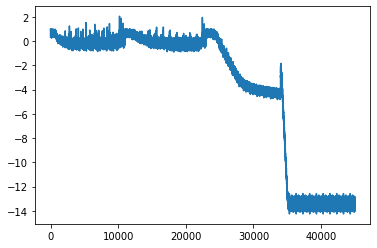

In [21]:
plt.plot([np.log10(x["loss"]) for x in lcc.history])

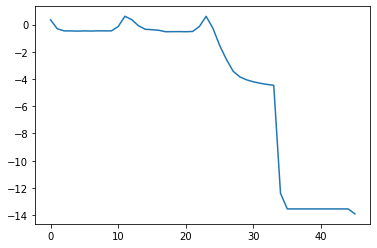

In [26]:
plt.plot([np.log10(x) for x in history.history["loss"]])

Text(0.5, 1.0, 'Deep iNALU Training - Seeds Comparison')

<Figure size 432x288 with 0 Axes>

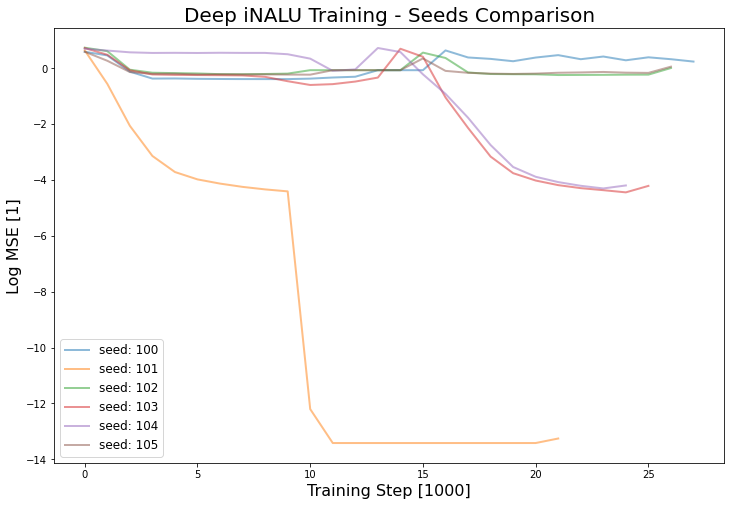

In [16]:
import matplotlib.pyplot as plt 


name = "deep"
steps = 6000
#
plt.rcParams['figure.facecolor'] = 'white'

plt.figure(figsize= tuple(map(lambda x: 2*x, plt.gcf().get_size_inches())))
# plt.margins(0)
line_width = 2.0
for seed, data in {k : v.history["loss_gate"] for k, v in res.items()}.items():
    p = plt.plot(list(map(lambda x: x/1, range(len(data)))), np.log10(data), label = f"seed: {seed}", linewidth=line_width, alpha=0.5)

leg = plt.legend(prop={'size': 12})
for line in leg.get_lines():
    line.set_linewidth(line_width)

plt.ylabel("Log MSE [1]", fontsize=16)
plt.xlabel("Training Step [1000]", fontsize=16)
# ax2 = plt.twiny()
# ax2.set_xticks(np.arange(steps//1000 + 1))
# ax2.set_xlabel("Epochs [1]", fontsize = 16)

plt.title("Deep iNALU Training - Seeds Comparison", fontsize=20)
